In [67]:
# === 0) Imports necesarios ===
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

In [ ]:
# === 1) Leer y preparar los datos para el modelo, variable X y variable Y ===

df = pd.read_csv("ventas_mensuales - TUM-Mod.csv", sep=";", decimal=".", encoding="Latin1") #Leer el archicvo CSV con separador ; y codificación Latin1
df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y") #Convertir la columna 'date' a formato datetime
df = df.set_index("date") #Establecer la columna 'date' como índice 
df["value"] = pd.to_numeric(df["value"])#Convertir la columna 'value' a numérico
y = df["value"] #Asignar la columna 'value' a la variable y

In [ ]:
# === 2) Condicional para modelar según si se tiene encuenta el COVID o no ===

covid = 0 # 0 = Sin datos de la etapa COVID; 1 = Con datos de la etapa COVID
COVID_START = "2020-03-01" # Fecha considerada de inicio del periodo COVID
COVID_END   = "2021-12-01" # Fecha considerada de fin del periodo COVID

# Condicional para enmascarar los datos del periodo COVID si covid == 0
if covid == 0:
    y_masked = y.copy()
    y_masked.loc[COVID_START:COVID_END] = np.nan
else:  
    y_masked = y.copy()


In [70]:
# === 3) Preparar las variables exógenas ===

#cols_exog = ["Sol","Precipitación","Agosto","Tendencia"]  # Sin festivos ni temperatura ni "ICC". Variables exógenas óptimas
cols_exog = ["Sol","Precipitación","Agosto","Tendencia","Festivos","Temperatura","ICC"]  # Con todas las variables exógenas disponibles.

for c in cols_exog: # Transformar y preparar las variables exógenas
    df[c] = df[c].astype(str) # Convertir a string para reemplazar comas
    df[c] = df[c].str.replace(",", ".", regex=False) # Reemplazar comas por puntos decimales
    df[c] = pd.to_numeric(df[c], errors="coerce") # Convertir a numérico, forzando errores a NaN

X = df[[c for c in cols_exog if c in df.columns]] # Crear la matriz de variables exógenas X

X_full = df[cols_exog]  # Crear la matriz completa de variables exógenas X_full

# Print para verificar tipos de datos y contenido
# print(df[cols_exog].dtypes)
# print(X_full.head())

In [71]:
# === 4) Definición de funciones para el cálculo de métricas de evaluación ===

# Root Mean Squared Error (RMSE)
def rmse(y_verd, y_pred):
    return np.sqrt(np.mean((y_pred - y_verd)**2))

# Mean Absolute Error (MAE) 
def mae(y_verd, y_pred):
    return np.mean(np.abs(y_pred - y_verd))

# Mean Absolute Percentage Error (MAPE) con denominador seguro
def mape_safe(y_verd, y_pred, eps=1.0):
    denom = np.maximum(np.abs(y_verd), eps)
    return np.mean(np.abs(y_pred - y_verd) / denom) * 100.0

# Symmetric Mean Absolute Percentage Error (SMAPE)
def smape(y_verd, y_pred, eps=1e-8):
    denom = np.abs(y_verd) + np.abs(y_pred)
    denom = np.where(denom < eps, eps, denom)
    return np.mean(2.0 * np.abs(y_pred - y_verd) / denom) * 100.0

# Weighted Absolute Percentage Error (WAPE)
def wape(y_verd, y_pred, eps=1e-8):
    return np.sum(np.abs(y_pred - y_verd)) / max(np.sum(np.abs(y_verd)), eps) * 100.0

# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_verd, y_pred):
    yt = np.log1p(np.maximum(y_verd, 0))
    yp = np.log1p(np.maximum(y_pred, 0))
    return np.sqrt(np.mean((yp - yt)**2))

# R-squared (R2) Score
def r2_score(y_verd, y_pred):
    var = np.var(y_verd)
    if var <= 0:
        return np.nan
    return 1.0 - np.sum((y_pred - y_verd)**2) / np.sum((y_verd - np.mean(y_verd))**2)

# Función para calcular todas las métricas anteriores
def metricas (y_verd, y_pred, eps_mape=1.0, prefix=""):
    return {
        f"{prefix}R2": r2_score(y_verd, y_pred),
        f"{prefix}RMSLE": rmsle(y_verd, y_pred),
        f"{prefix}RMSE": rmse(y_verd, y_pred),
        f"{prefix}MAE": mae(y_verd, y_pred),
        f"{prefix}MAPE_safe(%)": mape_safe(y_verd, y_pred, eps=eps_mape),
        f"{prefix}SMAPE(%)": smape(y_verd, y_pred),
        f"{prefix}WAPE(%)": wape(y_verd, y_pred),
    }


In [72]:
# === 5a) Valores constantes de los hiperparmámetros

CPS = 0.3         # changepoint_prior_scale
SPS = 1         # seasonality_prior_scale
SPS_CONST = 3    # seasonality_prior_scale constante en el modelo final         
# MONTHLY_ORDER = 3  # Fourier para mensual (Se comenta porque no se usa estacionalidad mensual)
YEARLY_ORDER=10 # Fourier para anual
YEARLY_ORDER_CONST=10 # Fourier anual constante en el modelo final      # changepoint_prior_scale  
REGRESSOR_PRIOR = 10   # prior scale para regresores exógenos
REGRESSOR_PRIOR_CONST = 2 # prior scale constante para regresores exógenos en el modelo final
PRIORS_BASE = {"Precipitación":10, "Agosto":10, "Sol":10, "Tendencia":10} # Priors base para cada variable exógena
priors_map = {r: REGRESSOR_PRIOR * PRIORS_BASE.get(r, 1.0) for r in cols_exog} # Mapa de priors para cada variable exógena

In [73]:
# === 5b) Preparar los conjuntos de entrenamiento y prueba ===

df_full = X.copy(); # Crear una copia de X para evitar modificar el original
df_full['ds'] = y_masked.index; # Crear la columna de inidices para Prophet
df_full['y'] = y_masked.values # Crear la columna de valores objetivo para Prophet

# Crear el DataFrame completo uniendo X y y_masked, alineando por índice y eliminando filas sin y que en este caso son las del periodo COVID si covid == 0
df_full = (
    X.join(y_masked.rename('y'))   # alinea por índice
     .reset_index(names='ds')      # el índice pasa a columna 'ds'
     .dropna(subset=['y'])         # quita filas sin y (para covid==0, las del periodo COVID)
)

# Dividir en conjuntos de entrenamiento y prueba (80% - 20%)
split = int(len(df_full) * 0.80) # Índice de división
train = df_full.iloc[:split].copy() # Conjunto de entrenamiento
test  = df_full.iloc[split:].copy() # Conjunto de prueba

# Se necesita más adelante para calculo de residuos
train_log = np.log(np.clip(train['y'], 1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)
test_log  = np.log(np.clip(test['y'],  1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)

In [74]:
# === 6) Configurar, entrenar y predecir con el modelo Prophet ===

def ejecutar_modelo_prophet(train, test, exogs, CPS, SPS, REGRESSOR_PRIOR):
   
    train_log = train.copy() # Crear copias de los conjuntos de entrenamiento 
    test_log = test.copy() # Crear copias de los conjuntos de prueba

    train_log['y'] = np.log(np.clip(train_log['y'], 1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)
    test_log['y']  = np.log(np.clip(test_log['y'],  1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)

    m = Prophet(
       
        seasonality_mode='additive', # Tipo de estacionalidad
        changepoint_prior_scale=CPS, # Escala de prior para puntos de cambio
        seasonality_prior_scale=SPS, # Escala de prior para estacionalidad
        interval_width=0.95 # Intervalo de confianza del 95%

    )

    m.add_seasonality(name='anual', period=365.25, fourier_order=YEARLY_ORDER) # Añadir estacionalidad anual con Fourier
    # m.add_seasonality(name="mensual", period=30.5, fourier_order=MONTHLY_ORDER)  # Añadir estacionalidad mensual con Fourier, no usada aquí
    
    exogs = exogs or [] # Asegurarse de que exogs es una lista, incluso si es None

    # Añadir regresores externos   
    for r in exogs:
        m.add_regressor(r, prior_scale=priors_map.get(r, REGRESSOR_PRIOR), standardize=True)

    # Entrenamiento del modelo con datos en log, ya que se está modelando en escala logarítmica
    m.fit(train_log[['ds', 'y'] + exogs]) # ds es el índice de fechas, y es la variable objetivo en escala logarítmica y cols_exog son las variables exógenas

    # Predecciones utilizando el modelo entrenado en el horizonte de test
    predicciones = m.predict(test_log[['ds'] + exogs])[['ds','yhat','yhat_lower','yhat_upper']] # Solo se necesitan las columnas 'ds' y 'yhat', yhat es un nombre estándar en Prophet que es el resultado predicho
    

    # Unir predicción con valores reales mediante la columna 'ds'
    inner_join = test_log[['ds','y']].merge(predicciones, on='ds', how='inner')
    y_real_lin = np.exp(inner_join['y'].to_numpy())      # deshacer log de y real
    y_pred_lin = np.exp(inner_join['yhat'].to_numpy())   # deshacer log de yhat
    inner_join['y_lin']     = np.exp(inner_join['y']) # deshacer log de y real
    inner_join['yhat_lin']  = np.exp(inner_join['yhat']) # deshacer log de yhat
    inner_join['lo_lin']    = np.exp(inner_join['yhat_lower']) # deshacer log de yhat_lower
    inner_join['hi_lin']    = np.exp(inner_join['yhat_upper']) # deshacer log de yhat_upper

    index_values = inner_join['ds'].values # Índices de fechas para el conjunto de prueba

    metrics = metricas(y_real_lin, y_pred_lin, eps_mape=1.0)# Calcular métricas de evaluación

    # Resultado final en un DataFrame conjunto
    # result = inner_join.assign(y_pred_normalizada=y_pred_lin)
    # print(result.head())  # Mostrar las primeras filas del DataFrame resultante

    return m, index_values, y_real_lin, y_pred_lin, metrics,inner_join

m, index_values, y_real_lin, y_pred_lin, metrics,inner_join = ejecutar_modelo_prophet(train, test, cols_exog,CPS, SPS, REGRESSOR_PRIOR)


22:15:10 - cmdstanpy - INFO - Chain [1] start processing
22:15:11 - cmdstanpy - INFO - Chain [1] done processing


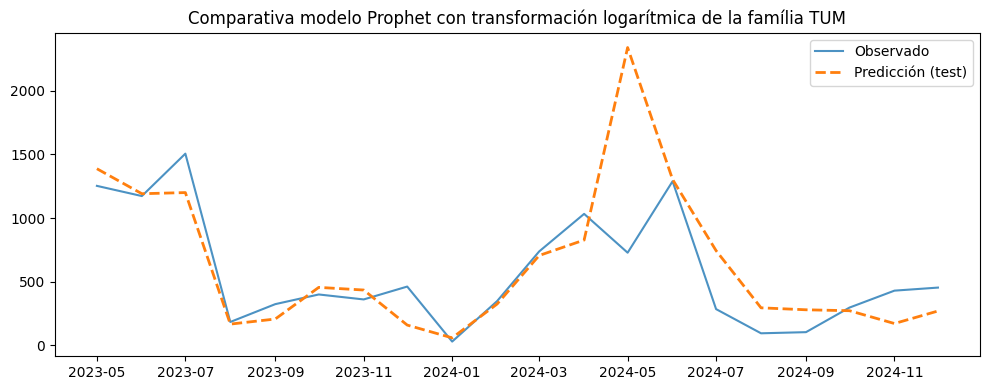

In [75]:
# === 7) Visualización de resultados comparando observado vs predicción modelo sin optimizar ===

plt.figure(figsize=(10,4))
plt.plot(index_values, y_real_lin, label="Observado", alpha=0.8)
plt.plot(index_values, y_pred_lin, "--", label="Predicción (test)", linewidth=2)
plt.title("Comparativa modelo Prophet con transformación logarítmica de la família TUM")
plt.legend()
plt.tight_layout()
plt.show()

In [76]:
# === 8) Elección de variables exógenas mediante ablación ===

rows = [] # Lista para almacenar resultados de ablación
for reg in cols_exog:
    exogs = [c for c in cols_exog if c != reg] # Excluir la variable actual
    _, _, _, _, metrics,_ = ejecutar_modelo_prophet(train, test, exogs,CPS, SPS, REGRESSOR_PRIOR) # Llamar a la función con las variables exógenas restantes
    rows.append({'drop': reg, **metrics}) # Almacenar el resultado con la variable eliminada
ablation_df = pd.DataFrame(rows).sort_values('RMSE') # Mostrar el DataFrame de ablación ordenado por RMSE
ablation_df # Mostrar el DataFrame de ablación ordenado por RMSE

22:15:11 - cmdstanpy - INFO - Chain [1] start processing
22:15:12 - cmdstanpy - INFO - Chain [1] done processing
22:15:12 - cmdstanpy - INFO - Chain [1] start processing
22:15:13 - cmdstanpy - INFO - Chain [1] done processing
22:15:13 - cmdstanpy - INFO - Chain [1] start processing
22:15:13 - cmdstanpy - INFO - Chain [1] done processing
22:15:14 - cmdstanpy - INFO - Chain [1] start processing
22:15:14 - cmdstanpy - INFO - Chain [1] done processing
22:15:14 - cmdstanpy - INFO - Chain [1] start processing
22:15:15 - cmdstanpy - INFO - Chain [1] done processing
22:15:15 - cmdstanpy - INFO - Chain [1] start processing
22:15:16 - cmdstanpy - INFO - Chain [1] done processing
22:15:16 - cmdstanpy - INFO - Chain [1] start processing
22:15:16 - cmdstanpy - INFO - Chain [1] done processing


,drop,R2,RMSLE,RMSE,MAE,MAPE_safe(%),SMAPE(%),WAPE(%)
3,Tendencia,0.385713,0.593728,339.674210,260.758468,53.631118,51.690793,45.372972
0,Sol,0.237646,0.604486,378.403624,216.340562,56.659892,43.841396,37.644086
4,Festivos,0.202602,0.610290,387.003128,216.149738,57.871487,43.974713,37.610882
5,Temperatura,0.144657,0.616539,400.817767,222.811189,56.906020,43.475900,38.770000
2,Agosto,0.067170,0.621440,418.579568,216.244133,59.938041,42.841617,37.627307
6,ICC,-0.096912,0.639855,453.902564,235.638192,65.012185,43.143826,41.001948
1,Precipitación,-0.324262,0.696109,498.728102,276.752438,76.452280,48.502087,48.155984


In [77]:
# === 9) Elección de variables exógenas mediante forward selection ===

# Función de forward selection
def forward_selection(train, test, candidates, max_k=None, metric='RMSE',fixed=None, CPS=CPS, SPS=SPS,  REGRESSOR_PRIOR=REGRESSOR_PRIOR):

    fixed = list(fixed or []) # Asegurar que 'fixed' es una lista
    pool = [c for c in candidates if c not in fixed] # Candidatas excluyendo las fijas
    selected = fixed[:]# Copia de las fijas
    best_score = None # Inicialización de la mejor puntuación incial
    history = [] # Historial de selecciones
    trials_log = [] # Lista de evaliaciones realizadas

    K = len(pool) if max_k is None else min(max_k, len(pool)) # Número máximo de iteraciones
    for step in range(1, K+1): # Iterar hasta K
        best_cand, best_mets = None, None # Inicializar el mejor candidato y métricas de la ronda
        for c in pool: # Iterar sobre las candidatas
            if c in selected: #
                continue
            trial = selected + [c] # Crear la lista de variables exógenas para esta prueba
            # Llamada de la función con keywords para no desplazar args
            _, _, _, _, mets, _ = ejecutar_modelo_prophet(
                train=train, test=test, exogs=trial,
                CPS=CPS, SPS=SPS,  REGRESSOR_PRIOR=REGRESSOR_PRIOR
            )
            # Guardar el resultado de la evaluación
            trials_log.append({'round': step, 'candidate': c, **mets}) # Almacenar el resultado de la evaluación
            # Selección del mejor de la ronda
            if (best_mets is None) or (mets[metric] < best_mets[metric]): # Comparar métricas para encontrar la mejor
                best_mets, best_cand = mets, c # Seleccionar el mejor candidato y sus métricas
        # Si no hay mejora, salir del bucle
        if best_cand is None:
            break
        # Comprobar si la mejor métrica mejora la mejor puntuación global
        if best_score is None or best_mets[metric] < best_score:
            selected.append(best_cand)
            best_score = best_mets[metric]
            history.append({'step': len(selected) - len(fixed), 'added': best_cand, **best_mets})
        else:
            break

    # Devolvemos sólo lo añadido respecto a las fijas
    added_only = [c for c in selected if c not in fixed]
    return added_only, pd.DataFrame(history), pd.DataFrame(trials_log)

# Variables fijas y candidatas
fijas = ["Sol","Precipitación","Agosto","Tendencia"]  # Exógenas optimizada ya en este momento.
cols_exog_añadir = ["Festivos","Temperatura","ICC"]  # Sin festivos ni Covid ni temperatura ni "ICC".
candidatas = cols_exog_añadir # Las variables candidatas

# Llamada de la función forward selection
added, hist, trials = forward_selection(
    train=train, test=test,
    candidates=cols_exog_añadir, fixed=fijas, metric='RMSE',
    CPS=CPS, SPS=SPS, REGRESSOR_PRIOR=REGRESSOR_PRIOR
)


22:15:17 - cmdstanpy - INFO - Chain [1] start processing
22:15:17 - cmdstanpy - INFO - Chain [1] done processing
22:15:17 - cmdstanpy - INFO - Chain [1] start processing
22:15:18 - cmdstanpy - INFO - Chain [1] done processing
22:15:18 - cmdstanpy - INFO - Chain [1] start processing
22:15:18 - cmdstanpy - INFO - Chain [1] done processing
22:15:18 - cmdstanpy - INFO - Chain [1] start processing
22:15:19 - cmdstanpy - INFO - Chain [1] done processing
22:15:19 - cmdstanpy - INFO - Chain [1] start processing
22:15:20 - cmdstanpy - INFO - Chain [1] done processing
22:15:20 - cmdstanpy - INFO - Chain [1] start processing
22:15:21 - cmdstanpy - INFO - Chain [1] done processing


In [78]:
# === 10) Análisis de la escala de los priors de los regresores exógenos ===

cols_exog_optimas= ["Sol","Precipitación","Agosto","Tendencia"] # Variables exógenas óptimas tras forward selection y ablación 

PRIORS_BASE = {"Precipitación":10, "Agosto":10, "Sol":10, "Tendencia":10} # Prior scales base para las variables exógenas óptimas

EXOG_USE = cols_exog_optimas # Variables exógenas a usar en el análisis de escala de priors

# Función para entrenar y evaluar el modelo con una escala dada de priors
def entrenar_sps(priors_map, sps=SPS, yearly_order=YEARLY_ORDER_CONST, cps=CPS):
   
    train_log = train.copy() # Crear copias de los conjuntos de entrenamiento 
    test_log = test.copy() # Crear copias de los conjuntos de prueba
    train_log['y'] = np.log(np.clip(train_log['y'], 1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)
    test_log['y']  = np.log(np.clip(test_log['y'],  1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)
   
   # Definición del modelo Prophet
    m = Prophet(
       
        seasonality_mode='additive', # Tipo de estacionalidad
        changepoint_prior_scale=cps, # Escala de prior para puntos de cambio
        seasonality_prior_scale=sps # Escala de prior para estacionalidad
    )
    
    # Añadir estacionalidad anual con Fourier
    m.add_seasonality(name="yearly", period=365.25, fourier_order=yearly_order)
    
    # Añadir regresores externos con las escalas de prior dadas
    for r in EXOG_USE:
        m.add_regressor(r, prior_scale=priors_map.get(r, 0.8), standardize=True)
    
    # Entrenamiento del modelo con datos en log, ya que se está modelando en escala logarítmica
    m.fit(train_log[["ds","y"]+EXOG_USE])
    
    predicciones = m.predict(test_log[["ds"]+EXOG_USE])[["ds","yhat"]] # Solo se necesitan las columnas 'ds' y 'yhat', yhat es un nombre estándar en Prophet que es el resultado predicho
    evaluacion = test[["ds","y"]].merge(predicciones, on="ds") # Unir predicción con valores reales mediante la columna 'ds'
    yhat = np.exp(predicciones["yhat"].values) # Deshacer logaritmo de yhat
    mets = metricas(evaluacion["y"].values, yhat) # Calcular métricas de evaluación
    return mets

scales = [0.1, 0.3, 0.8, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0] # Escalas a probar
curva = [] # Lista para almacenar resultados de las diferentes escalas

# Iterar sobre las diferentes escalas y entrenar el modelo
for s in scales:
    pri = {k: v*s for k,v in PRIORS_BASE.items()}  # Miltiplicador global
    mets = entrenar_sps(pri, sps=SPS,yearly_order=YEARLY_ORDER_CONST, cps=CPS)
    curva.append({"scale": s, **mets})
pd.DataFrame(curva).sort_values("RMSE")

22:15:21 - cmdstanpy - INFO - Chain [1] start processing
22:15:21 - cmdstanpy - INFO - Chain [1] done processing
22:15:21 - cmdstanpy - INFO - Chain [1] start processing
22:15:22 - cmdstanpy - INFO - Chain [1] done processing
22:15:22 - cmdstanpy - INFO - Chain [1] start processing
22:15:22 - cmdstanpy - INFO - Chain [1] done processing
22:15:22 - cmdstanpy - INFO - Chain [1] start processing
22:15:23 - cmdstanpy - INFO - Chain [1] done processing
22:15:23 - cmdstanpy - INFO - Chain [1] start processing
22:15:23 - cmdstanpy - INFO - Chain [1] done processing
22:15:23 - cmdstanpy - INFO - Chain [1] start processing
22:15:24 - cmdstanpy - INFO - Chain [1] done processing
22:15:24 - cmdstanpy - INFO - Chain [1] start processing
22:15:24 - cmdstanpy - INFO - Chain [1] done processing
22:15:24 - cmdstanpy - INFO - Chain [1] start processing
22:15:25 - cmdstanpy - INFO - Chain [1] done processing
22:15:25 - cmdstanpy - INFO - Chain [1] start processing
22:15:25 - cmdstanpy - INFO - Chain [1]

,scale,R2,RMSLE,RMSE,MAE,MAPE_safe(%),SMAPE(%),WAPE(%)
5,3.0,-0.401152,0.666237,513.002548,253.938311,69.188459,43.216674,44.186238
3,1.0,-0.431459,0.667382,518.520944,255.972048,69.728078,43.224408,44.540116
8,10.0,-0.434141,0.668298,519.006534,255.844339,69.829123,43.247057,44.517894
2,0.8,-0.505384,0.672360,531.741374,263.553953,71.722870,43.733950,45.859397
1,0.3,-0.505785,0.672330,531.812165,263.512219,71.701608,43.730773,45.852135
7,5.0,-0.511176,0.673782,532.763305,264.849335,71.909029,43.892263,46.084798
6,4.0,-0.512809,0.673941,533.051220,265.064734,71.971562,43.912129,46.122278
4,2.0,-0.513110,0.673952,533.104097,265.082591,71.969071,43.912409,46.125386
0,0.1,-0.516881,0.672967,533.767990,264.396601,71.906137,43.816782,46.006021


In [79]:
# === 11) Búsqueda en cuadrícula de hiperparámetros de estacionalidad anual === 
                
SPS_LIST = [3, 6, 10]   # Listado de seasonality_prior_scale 
YEARLY_ORDER = [3,4,5,6,8,10,12,18,24]  #  Listado de fourier_order anual
cols_exog_optimas= ["Sol","Precipitación","Agosto","Tendencia"] # Variables exógenas óptimas tras forward selection y ablación 

EXOG_USE = cols_exog_optimas # Variables exógenas a usar en el análisis de escala de SPS y yearly_order
PRIORS_BASE = {"Precipitación":10, "Agosto":10, "Sol":10, "Tendencia":10}

# Función para entrenar y evaluar el modelo con una combinación dada de hiperparámetros
def fit_eval_log(exogs, cps, sps, yearly_order, priors):

    train_log = train.copy() # Crear copias de los conjuntos de entrenamiento 
    test_log = test.copy() # Crear copias de los conjuntos de prueba
    train_log['y'] = np.log(np.clip(train_log['y'], 1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)
    test_log['y']  = np.log(np.clip(test_log['y'],  1e-6, None)) # Aplicar logaritmo con gestión para para evitar log(0)

    m = Prophet(
       
        seasonality_mode='additive', # Tipo de estacionalidad
        changepoint_prior_scale=cps, # Escala de prior para puntos de cambio
        seasonality_prior_scale=sps # Escala de prior para estacionalidad
    )
    
    m.add_seasonality(name="yearly", period=365.25, fourier_order=yearly_order)

    for r in exogs:
        m.add_regressor(r, prior_scale=priors.get(r, 0.8), standardize=True)

    m.fit(train_log[["ds","y"] + exogs])
    predicciones = m.predict(test_log[["ds"] + exogs])[["ds","yhat"]]
    evaluacion = test[["ds","y"]].merge(predicciones, on="ds") 
    yhat = np.exp(evaluacion["yhat"].values)
    mets = metricas(evaluacion["y"].values, yhat)
    return mets

rows = [] # Lista para almacenar resultados de la cuadrícula
# Iterar sobre combinaciones de hiperparámetros
for sps in SPS_LIST:
    for yo in YEARLY_ORDER:
        mets = fit_eval_log(EXOG_USE, CPS, sps, yo, PRIORS_BASE)
        rows.append({"seasonality_prior_scale": sps, "yearly_order": yo, **mets})

# Crear DataFrame con los resultados y ordenarlo por RMSE y MAPE
grid_year = pd.DataFrame(rows).sort_values(["RMSE","MAPE_safe(%)"], ascending=[True, True])

# Mostrar las 15 mejores combinaciones de hiperparámetros
display(grid_year.head(15))



22:15:25 - cmdstanpy - INFO - Chain [1] start processing
22:15:25 - cmdstanpy - INFO - Chain [1] done processing
22:15:25 - cmdstanpy - INFO - Chain [1] start processing
22:15:26 - cmdstanpy - INFO - Chain [1] done processing
22:15:26 - cmdstanpy - INFO - Chain [1] start processing
22:15:26 - cmdstanpy - INFO - Chain [1] done processing
22:15:26 - cmdstanpy - INFO - Chain [1] start processing
22:15:27 - cmdstanpy - INFO - Chain [1] done processing
22:15:27 - cmdstanpy - INFO - Chain [1] start processing
22:15:27 - cmdstanpy - INFO - Chain [1] done processing
22:15:27 - cmdstanpy - INFO - Chain [1] start processing
22:15:27 - cmdstanpy - INFO - Chain [1] done processing
22:15:28 - cmdstanpy - INFO - Chain [1] start processing
22:15:28 - cmdstanpy - INFO - Chain [1] done processing
22:15:28 - cmdstanpy - INFO - Chain [1] start processing
22:15:29 - cmdstanpy - INFO - Chain [1] done processing
22:15:29 - cmdstanpy - INFO - Chain [1] start processing
22:15:29 - cmdstanpy - INFO - Chain [1]

,seasonality_prior_scale,yearly_order,R2,RMSLE,RMSE,MAE,MAPE_safe(%),SMAPE(%),WAPE(%)
23,10,10,0.057455,0.645197,420.753595,232.720893,64.492011,42.230843,40.494326
14,6,10,-0.036254,0.648273,441.174068,234.040068,64.701598,42.135534,40.723868
1,3,4,-0.133096,0.681903,461.328346,319.646537,78.178227,50.067782,55.619721
19,10,4,-0.137861,0.682441,462.297377,320.279417,78.305259,50.109518,55.729845
10,6,4,-0.153635,0.685082,465.490740,322.614274,79.180780,50.320143,56.136119
0,3,3,-0.160032,0.684261,466.779592,325.175748,79.249353,50.403380,56.581825
21,10,6,-0.173630,0.673789,469.507482,315.434555,78.522151,49.925722,54.886820
18,10,3,-0.191581,0.686877,473.084394,328.670822,79.674943,50.577621,57.189981
9,6,3,-0.199737,0.687641,474.700771,329.872712,80.204896,50.655238,57.399115
12,6,6,-0.206850,0.676155,476.105811,318.857583,78.899472,50.078123,55.482440


In [80]:
# 12 === Búsqueda en cuadrícula del hiperparámetros CPS === 
 
CPS_LIST = [0.01, 0.03, 0.05, 0.08, 0.10, 0.20,0.03,0.3,0.5] # Listado de changepoint_prior_scale
SPS_CONST = 10  # seasonality_prior_scale constante en el modelo final
YEARLY_ORDER=10 # Fourier para anual

rows = []
# Iterar sobre combinaciones de changepoint_prior_scale 
for cps in CPS_LIST: # Iterar sobre valores de CPS
    mets = fit_eval_log(EXOG_USE, cps, sps, YEARLY_ORDER, priors=PRIORS_BASE) # Llamar a la función con los hiperparámetros actuales
    rows.append({"CPS":cps, "SPS":sps, **mets}) # Almacenar el resultado con la variable eliminada

grid_cs = pd.DataFrame(rows).sort_values(["RMSE","MAPE_safe(%)"], ascending=[True, True]) # Mostrar las 10 mejores combinaciones de hiperparámetros
display(grid_cs.head(10))

22:15:38 - cmdstanpy - INFO - Chain [1] start processing
22:15:38 - cmdstanpy - INFO - Chain [1] done processing
22:15:38 - cmdstanpy - INFO - Chain [1] start processing
22:15:38 - cmdstanpy - INFO - Chain [1] done processing
22:15:38 - cmdstanpy - INFO - Chain [1] start processing
22:15:39 - cmdstanpy - INFO - Chain [1] done processing
22:15:39 - cmdstanpy - INFO - Chain [1] start processing
22:15:39 - cmdstanpy - INFO - Chain [1] done processing
22:15:39 - cmdstanpy - INFO - Chain [1] start processing
22:15:39 - cmdstanpy - INFO - Chain [1] done processing
22:15:39 - cmdstanpy - INFO - Chain [1] start processing
22:15:39 - cmdstanpy - INFO - Chain [1] done processing
22:15:40 - cmdstanpy - INFO - Chain [1] start processing
22:15:40 - cmdstanpy - INFO - Chain [1] done processing
22:15:40 - cmdstanpy - INFO - Chain [1] start processing
22:15:40 - cmdstanpy - INFO - Chain [1] done processing
22:15:40 - cmdstanpy - INFO - Chain [1] start processing
22:15:41 - cmdstanpy - INFO - Chain [1]

,CPS,SPS,R2,RMSLE,RMSE,MAE,MAPE_safe(%),SMAPE(%),WAPE(%)
5,0.20,10,0.189033,0.633864,390.281857,226.562128,60.332034,41.976291,39.422678
1,0.03,10,0.158667,0.638287,397.521669,227.963218,64.142495,42.383905,39.666473
6,0.03,10,0.158667,0.638287,397.521669,227.963218,64.142495,42.383905,39.666473
2,0.05,10,0.147560,0.639358,400.136935,228.672052,64.494254,42.408564,39.789812
3,0.08,10,0.145373,0.639527,400.650025,228.757611,64.513364,42.405758,39.804700
4,0.10,10,0.139913,0.639796,401.927775,229.202824,64.571449,42.406277,39.882169
0,0.01,10,0.132157,0.640918,403.735930,229.571574,64.917257,42.435502,39.946333
7,0.30,10,0.057455,0.645197,420.753595,232.720893,64.492011,42.230843,40.494326
8,0.50,10,-0.679571,0.704183,561.663176,295.486192,81.756334,46.503900,51.415729


In [81]:
# === 13a) Valores constantes de los hiperparmámetros para el modelo final con todas las variables exógenas ===

CPS = 0.5         # changepoint_prior_scale
SPS_CONST = 10   # seasonality_prior_scale constante en el modelo final         
YEARLY_ORDER=10 # Fourier para anual
REGRESSOR_PRIOR_CONST = 3 # prior scale constante para regresores exógenos en el modelo final

In [82]:
# === 13b) Evaluación del modelo final con todas las variables exógenas ===

m_optimo, index_values, y_real_lin_optimo, y_pred_lin_optimo, metrics,inner_join = ejecutar_modelo_prophet(train, test, cols_exog_optimas,CPS, SPS_CONST, REGRESSOR_PRIOR_CONST)
# Impresión de las métricas
for k, v in metrics.items():
    suf = "%" if any(x in k for x in ["WAPE","SMAPE","MAPE"]) else ""
    print(f"{k}: {v:,.2f}{suf}")


22:15:41 - cmdstanpy - INFO - Chain [1] start processing
22:15:41 - cmdstanpy - INFO - Chain [1] done processing


R2: -0.40
RMSLE: 0.69
RMSE: 512.32
MAE: 271.29
MAPE_safe(%): 76.27%
SMAPE(%): 44.74%
WAPE(%): 47.20%


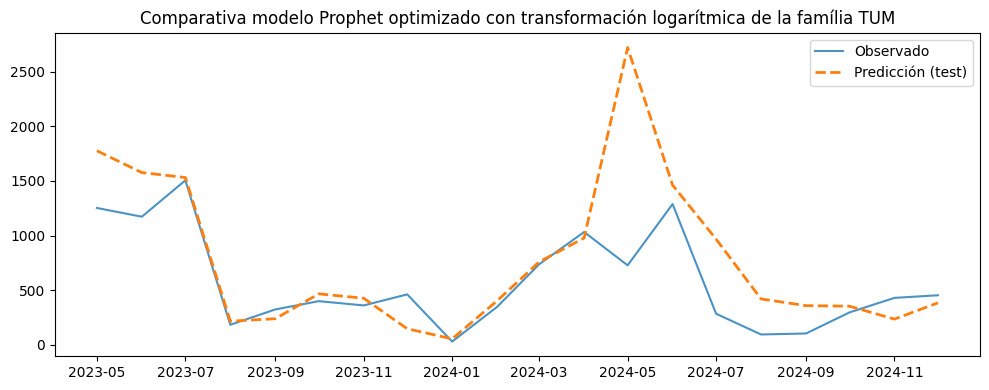

In [83]:
# === 14)  Visualización de resultados comparando observado vs predicción modelo optimizado ===

plt.figure(figsize=(10,4)) # Tamaño de la figura
plt.plot(index_values, y_real_lin_optimo, label="Observado", alpha=0.8) # Línea del valor observado
plt.plot(index_values, y_pred_lin_optimo, "--", label="Predicción (test)", linewidth=2) # Línea de la predicción
plt.title("Comparativa modelo Prophet optimizado con transformación logarítmica de la família TUM") # Título del gráfico
plt.legend() # Leyenda
plt.tight_layout() # Ajuste del diseño
plt.show() # Mostrar el gráfico

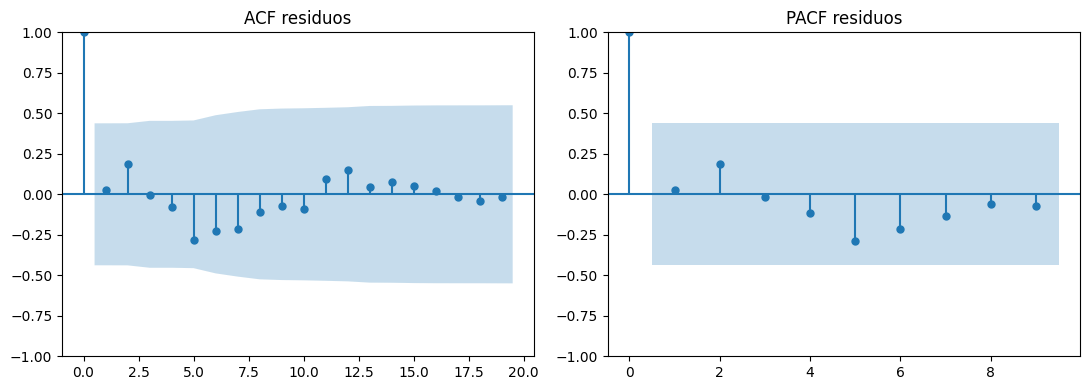

      lb_stat  lb_pvalue
19  10.602156   0.936497
9    7.151105   0.621391


In [84]:
# === 15) Análisis de los residuos del modelo optimizado ===

n = min(len(index_values), len(y_real_lin_optimo), len(y_pred_lin_optimo)) # Número de puntos de datos
# Cálculo de residuos
resid = pd.Series(
    np.asarray(y_real_lin_optimo, dtype=float) - np.asarray(y_pred_lin_optimo, dtype=float),
    index=pd.to_datetime(index_values),
    name="resid"
).dropna()
resid = resid - resid.mean() # Centrar residuos en media cero
lags_acf  = max(1, min(24, n - 1))    # Número de lags para ACF     
lags_pacf = max(1, min(24, n//2 - 1))  # Número de lags para PACF    
fig, ax = plt.subplots(1, 2, figsize=(11,4))
plot_acf(resid, lags=lags_acf, ax=ax[0])
plot_pacf(resid, lags=lags_pacf, ax=ax[1], method="ywm")
ax[0].set_title("ACF residuos")
ax[1].set_title("PACF residuos")
plt.tight_layout(); plt.show()

print(sm.stats.acorr_ljungbox(resid, lags=[lags_acf,lags_pacf], return_df=True))

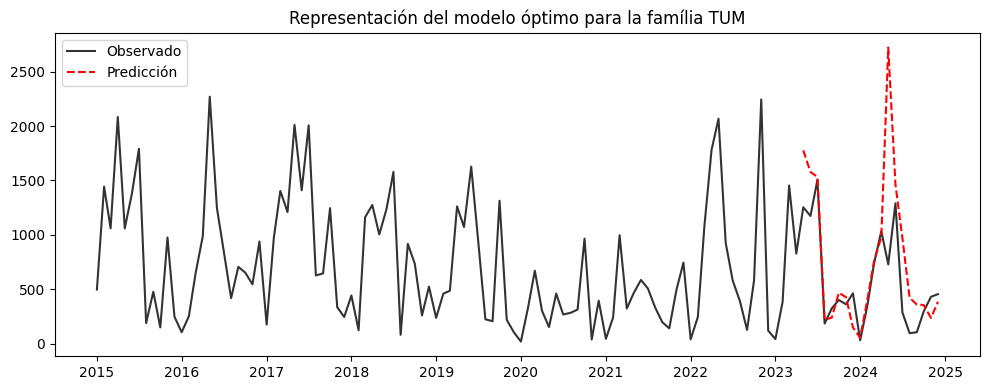

In [85]:
#== 16) Representación de la predicción del modelo óptimo completo ===

plt.figure(figsize=(10,4))
plt.plot(y, label="Observado", color="black", alpha=0.8)
plt.plot(index_values, y_pred_lin_optimo, "--", label="Predicción", color="red")
plt.title("Representación del modelo óptimo para la família TUM")
plt.legend(); plt.tight_layout(); plt.show()

Cobertura del intervalo 95% en test: 75.0%


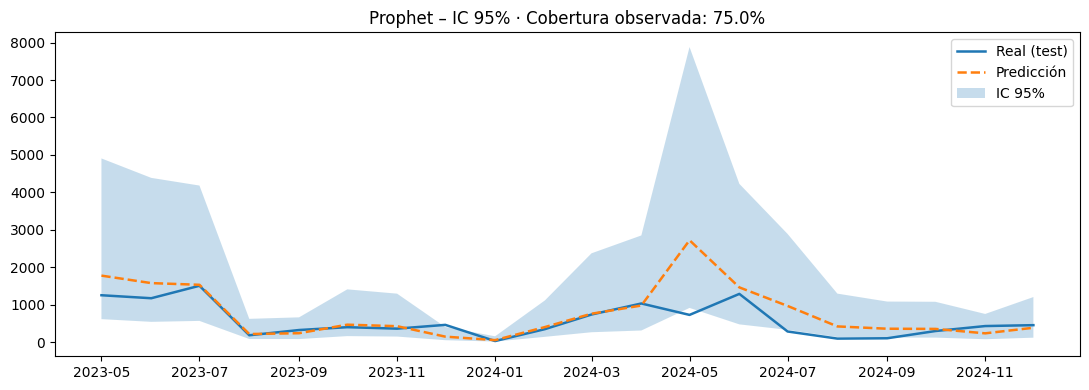

In [86]:
# === 17) Cobertura del intervalo de confianza al 95% ===

# DataFrame con valores observados y predichos en escala lineal
df_cov = test[['ds','y']].merge(inner_join[['ds','yhat_lin','lo_lin','hi_lin']], on='ds', how='inner')\
                         .set_index('ds')\
                         .rename(columns={'yhat_lin':'yhat','lo_lin':'lo','hi_lin':'hi'})

#Cobertura observada (IC 95%)
coverage = float(((df_cov['y'] >= df_cov['lo']) & (df_cov['y'] <= df_cov['hi'])).mean() * 100)
print(f"Cobertura del intervalo 95% en test: {coverage:.1f}%")

# Gráfico de la predicción con intervalo de confianza
plt.figure(figsize=(11,4))
plt.plot(df_cov.index, df_cov['y'], label='Real (test)', linewidth=1.8)
plt.plot(df_cov.index, df_cov['yhat'], '--', label='Predicción', linewidth=1.8)
plt.fill_between(df_cov.index, df_cov['lo'], df_cov['hi'], alpha=0.25, label='IC 95%')
plt.title(f"Prophet – IC 95% · Cobertura observada: {coverage:.1f}%")
plt.legend(); plt.tight_layout(); plt.show()

In [87]:
# === 18) Cálculo de métricas para el modelo base naive y_{t-12} ===

hist = df_full.set_index("ds")["y"] # Crear serie histórica completa
yhat_naive = hist.shift(12).reindex(test["ds"]).values # Desplazar 12 meses para el modelo naive
baseline_metrics = metricas(test["y"].values, yhat_naive) # Calcular métricas para el modelo naive
print("Baseline", baseline_metrics) 

Baseline {'R2': -1.0674235196774275, 'RMSLE': 0.8212086598736974, 'RMSE': 623.1484975509449, 'MAE': 405.85, 'MAPE_safe(%)': 99.65202410553445, 'SMAPE(%)': 58.19287532387476, 'WAPE(%)': 70.61945362797981}


In [ ]:
# === 19) Cálculo de métricas para el modelo sin transformación logarítmica ===

m_sin_ln = Prophet( #   Definición del modelo Prophet
       
        seasonality_mode='additive', # Tipo de estacionalidad
        changepoint_prior_scale=CPS, # Escala de prior para puntos de cambio
        seasonality_prior_scale=SPS, # Escala de prior para estacionalidad
        interval_width=0.95 # Intervalo de confianza del 95%

    )

m_sin_ln.add_seasonality(name='anual', period=365.25, fourier_order=YEARLY_ORDER) # Añadir estacionalidad anual con Fourier

# Añadir regresores externos sin transformación logarítmica
for r in cols_exog_optimas:
        m_sin_ln.add_regressor(r, prior_scale=priors_map.get(r, REGRESSOR_PRIOR), standardize=True)


m_sin_ln.fit(train) # Entrenamiento del modelo sin logaritmo


forecast_test = m_sin_ln.predict(test[["ds","Sol","Precipitación","Agosto","Tendencia"]]) # Predecir en el conjunto de prueba

cols_pred = ["ds"] + list(cols_exog_optimas)  # Columnas para predicción
forecast_test = m_sin_ln.predict(test[cols_pred]) # Predecir en el conjunto de prueba

# Preparar DataFrame para evaluación
eval_df = (
    pd.merge(
        test[['ds','y']], 
        forecast_test[['ds','yhat']], 
        on='ds', how='inner'
    )
    .dropna(subset=['y','yhat'])
    .reset_index(drop=True)
)

# Extraer valores reales y predichos
y_true = eval_df['y'].values
y_pred = eval_df['yhat'].values

# Calcular y mostrar métricas
res = metricas(y_true, y_pred,eps_mape=1.0)
for k, v in res.items():
    print(f"{k}: {v:.6f}")

22:15:42 - cmdstanpy - INFO - Chain [1] start processing
22:15:43 - cmdstanpy - INFO - Chain [1] done processing


R2: 0.186412
RMSLE: 0.707228
RMSE: 390.912133
MAE: 275.729111
MAPE_safe(%): 90.657016
SMAPE(%): 50.798004
WAPE(%): 47.977921
